In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import style
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures

from graph import mesh2Dgrid

style.use('fivethirtyeight')
np.set_printoptions(precision=4)


In [2]:
k = 5
h = 0.01
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])  # mesh plot
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])  # colors
trainColor = ['r', 'b']
predictColor = ['B', 'g']


In [3]:

def get_score(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    score = model.score(x_test, y_test)
    return score


def crossFold(model, X, y, k):
    kf = KFold(n_splits=k)

    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        score = get_score(model, X_train, y_train, X_test, y_test)
        scores.append(score)
    return scores


In [4]:

degress = [i for i in range(1, 10)]

df = pd.read_csv("datasets/microchips.csv")

# Train Data.
X = np.array(df.drop(['id'], 1))
y = np.array(df['id'])

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)


/tmp/ipykernel_115642/3507078879.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(df.drop(['id'], 1))


Degree 1
Accuracy: 0.5
Precision: 0.47058823529411764
Recall: 0.5714285714285714


/tmp/ipykernel_115642/2776877432.py:39: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plti.pcolormesh(xx, yy, clz_mesh, cmap=cmap_light)


ValueError: 'color' kwarg must be a color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

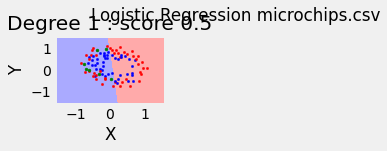

In [5]:

#
plt.suptitle("Logistic Regression {}".format("microchips.csv"))
for d in degress:

    # Create polynomial.
    poly = PolynomialFeatures(d, include_bias=False)
    Xdeg = poly.fit_transform(x_train)
    XTdeg = poly.fit_transform(x_test)

    # Train model.
    model = LogisticRegression(C=1.0, penalty='l2', solver='lbfgs')
    model.fit(Xdeg, y_train)

    #
    score = model.score(XTdeg, y_test)
    predicted = model.predict(XTdeg)
    cm = metrics.confusion_matrix(y_test, predicted)
    print("Degree {}".format(d))
    print("Accuracy:", metrics.accuracy_score(y_test, predicted))
    print("Precision:", metrics.precision_score(y_test, predicted))
    print("Recall:", metrics.recall_score(y_test, predicted))

    #
    plti = plt.subplot(3, 3, d)
    plti.set_xlabel("X")
    plti.set_ylabel("Y")
    plti.set_title("Degree {} : score {}".format(d, round(score, 4)))

    xx, yy, x1, x2 = mesh2Dgrid((-1.5, -1.5), (1.5, 1.5), h)

    # Create map of all point to test.
    map = poly.fit_transform([[_x, _y] for _x, _y in zip(x1, x2)])

    #
    predictedMap = model.predict(map)
    # results = results > 0.5

    clz_mesh = predictedMap.reshape(xx.shape)  # return to mesh format
    plti.pcolormesh(xx, yy, clz_mesh, cmap=cmap_light)

    for x_, y_ in zip(x_train, y_train):
        plti.scatter(x_[0], x_[1], color=trainColor[y_], cmap=cmap_bold, s=5)

    for x_, y_ in zip(x_test, predicted):
        plti.scatter(x_[0], x_[1], color=predictColor[y_], cmap=cmap_bold, s=8)

#
plt.show()


In [ ]:

# Cross validation
for d in degress:

    # Create polynomial.
    poly = PolynomialFeatures(d, include_bias=False)
    Xdeg = poly.fit_transform(X)
    XTdeg = poly.fit_transform(x_test)

    # Train model.
    model = LogisticRegression(C=1.0, penalty='l2', solver='lbfgs')
    Regscores = crossFold(model, Xdeg, y, k)

    model = LogisticRegression(C=999999.0, penalty='l2', solver='lbfgs')
    Unscores = crossFold(model, Xdeg, y, k)

    plti = plt.subplot(3, 3, d)
    for i, regSc in enumerate(Regscores):
        # label="Regularization")
        plti.scatter(i + 1, regSc, color='b', cmap=cmap_bold)
    for i, UnregSc in enumerate(Unscores):
        # label="Without regularization")
        plti.scatter(i + 1, UnregSc, color='r', cmap=cmap_bold)

    plti.legend(loc='upper left')
    plti.set_xlabel("K:nth fold")
    plti.set_ylabel("Score")
    plti.set_title("Degree {}".format(d))

plt.show()
print("Blue: Regularization \nRed: Without regularization")
